In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

# Load your local file (adjust the path if needed)
df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


(41188, 21)
y
no     36548
yes     4640
Name: count, dtype: int64
y
no     88.73
yes    11.27
Name: proportion, dtype: float64


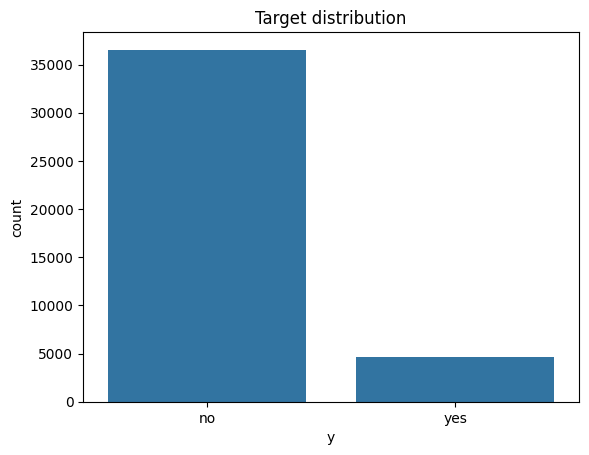

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [5]:
print(df.shape)
print(df.y.value_counts())
print(round(df.y.value_counts(normalize=True)*100, 2))

# Replace 'unknown' with NaN for quick visibility (optional)
eda_df = df.replace('unknown', np.nan)

# Target distribution
sns.countplot(x='y', data=df)
plt.title("Target distribution")
plt.show()

# Numeric overview
numeric_cols = eda_df.select_dtypes(include=[np.number]).columns
eda_df[numeric_cols].describe().T


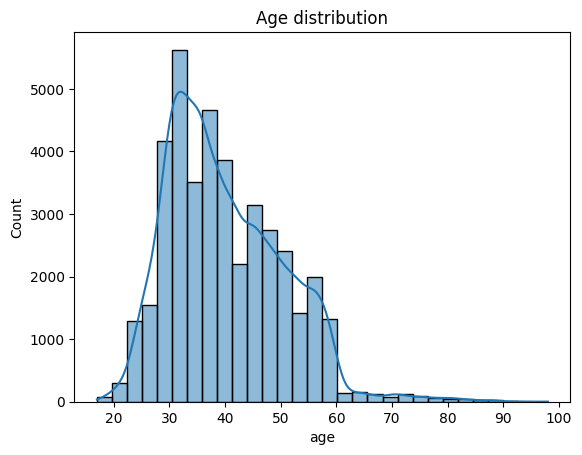

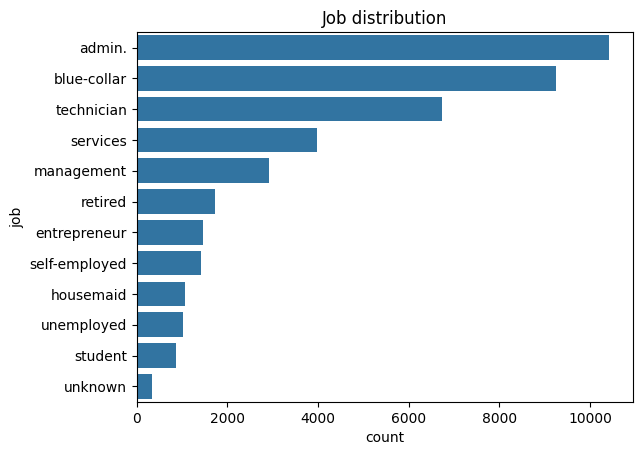

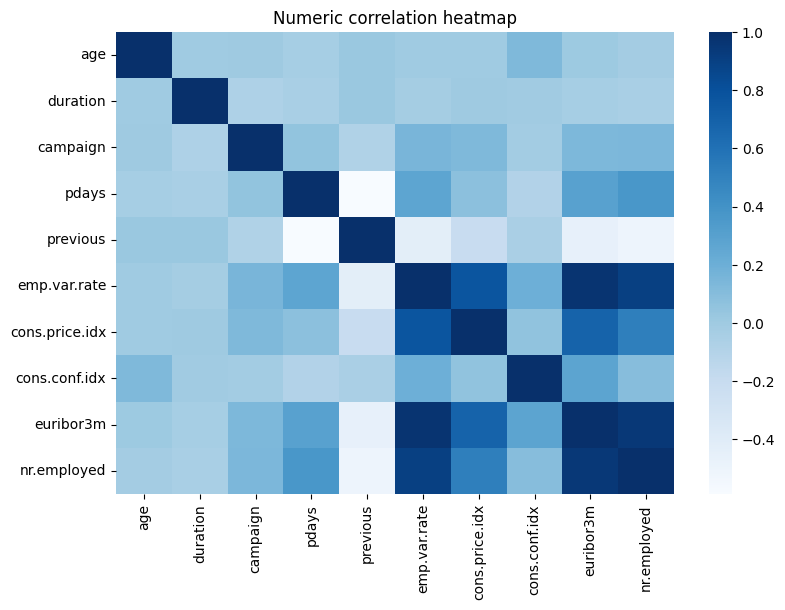

In [6]:
# Age
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age distribution"); plt.show()

# Job distribution (top categories)
order = df['job'].value_counts().index
sns.countplot(y='job', data=df, order=order)
plt.title("Job distribution"); plt.show()

# Correlation among numeric features
plt.figure(figsize=(9,6))
sns.heatmap(df[numeric_cols].corr(), cmap='Blues', annot=False)
plt.title("Numeric correlation heatmap"); plt.show()


In [7]:
df_model = df.copy()

# Drop leakage column
if 'duration' in df_model.columns:
    df_model = df_model.drop(columns=['duration'])

# Separate target
y = df_model['y'].map({'no':0, 'yes':1})
X = df_model.drop(columns=['y'])

# Identify column types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_cols, cat_cols


(['age',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
# One-hot encode categoricals; keep numeric as-is
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# Base model (use class_weight to address imbalance)
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", dt)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8469288662296673
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      7310
           1       0.32      0.33      0.33       928

    accuracy                           0.85      8238
   macro avg       0.62      0.62      0.62      8238
weighted avg       0.85      0.85      0.85      8238



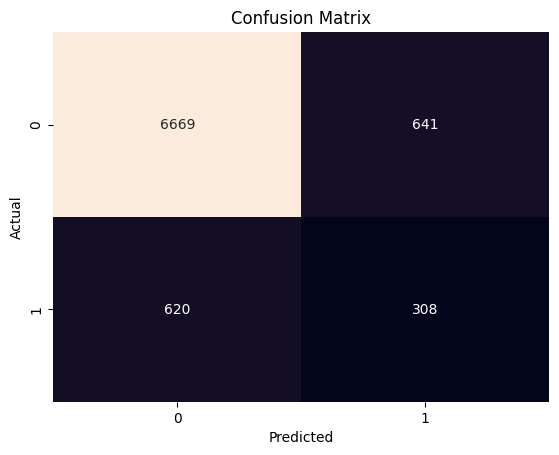

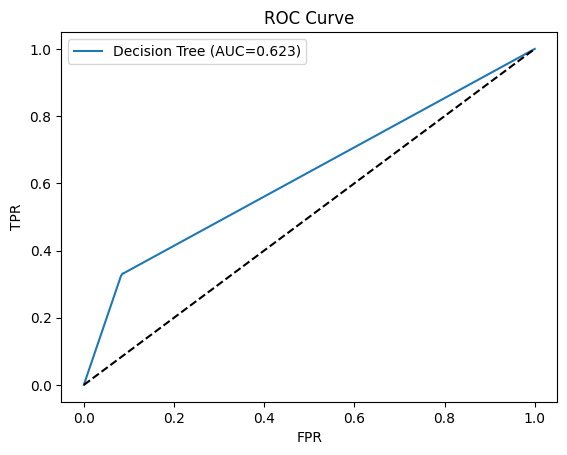

In [11]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

y_prob = pipe.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"Decision Tree (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.title("ROC Curve"); plt.show()


Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 20, 'clf__min_samples_split': 2}
Best CV AUC: 0.780936577641552
Test Accuracy (best): 0.8357611070648215
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7310
           1       0.37      0.66      0.48       928

    accuracy                           0.84      8238
   macro avg       0.66      0.76      0.69      8238
weighted avg       0.89      0.84      0.85      8238



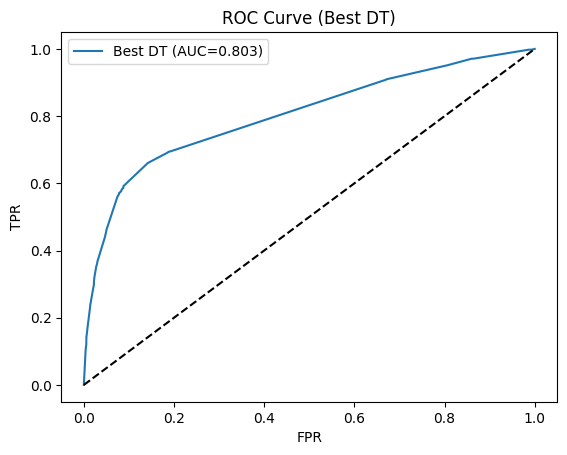

In [12]:
param_grid = {
    "clf__max_depth": [4, 6, 8, 10, 12],
    "clf__min_samples_split": [2, 10, 20, 50],
    "clf__min_samples_leaf": [1, 5, 10, 20],
    "clf__criterion": ["gini", "entropy"]
}

grid = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="roc_auc", cv=5, n_jobs=-1, verbose=1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:,1]

print("Test Accuracy (best):", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

auc_best = roc_auc_score(y_test, y_prob_best)
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
plt.plot(fpr, tpr, label=f"Best DT (AUC={auc_best:.3f})")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.title("ROC Curve (Best DT)"); plt.show()


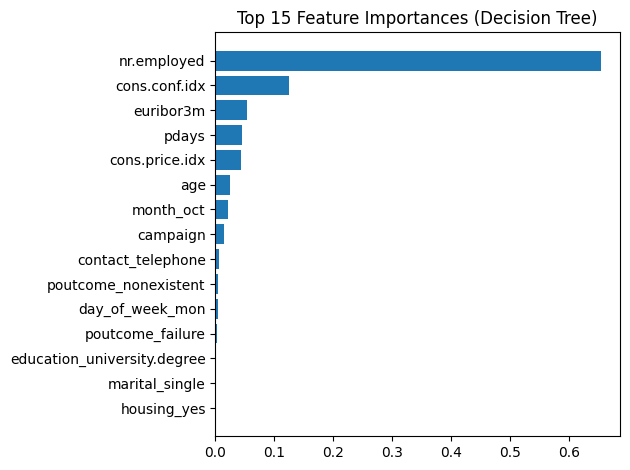

In [14]:
# Get feature names after OneHot
ohe = best_model.named_steps["prep"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_cols)
all_features = np.r_[ohe_features, num_cols]

dt_final = best_model.named_steps["clf"]
importances = dt_final.feature_importances_

# Top 15
idx = np.argsort(importances)[-15:]
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), all_features[idx])
plt.title("Top 15 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()
